In [1]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import json
import cv2
import glob
os.environ["OPENCV_LOG_LEVEL"]="SILENT"



## Inventory Attributes

In [2]:
import os
import sys
from brails import Importer

# sys.path.insert(1, "../../")

# This script needs a Google API Key to run.
# We suggest placing your API key in file apiKey.txt in the same directory as 
# this script if you plan to commit changes to this example. This way, you do 
# not risk accidentally uploading your API key (apiKey.txt is in .gitignore, 
# so you have work to do to get it uploaded)

apiKey = ""
if os.path.exists("apiKey.txt"):
    with open("apiKey.txt", "r") as file:
        apiKey = file.readline().strip()  # Read the first line and strip whitespace

# Create the importer:
importer = Importer()

# Select a region and create its RegionBoundary:
region_data = {"type": "locationName", "data": "Tiburon, CA"}
region_boundary_class = importer.get_class("RegionBoundary")
region_boundary_object = region_boundary_class(region_data)

# Get AssetInventory for buildings in the defined region via 
# USA_FootprintScraper:
print("Running USA_FootprintsScraper...")

usa_class = importer.get_class("USA_FootprintScraper")
usa_data = {"length": "ft"}
instance2 = usa_class(usa_data)
usa_inventory = instance2.get_footprints(region_boundary_object)

print("\nTotal number of assets detected using FEMA USA Structures data: "
      , len(usa_inventory.inventory))

# Subsample from the extracted assets to keep the image downloading step quick.
# Here, we are randomly sampling 15 buildings using a random seed value of 40:
small_inventory = usa_inventory.get_random_sample(15, 40)
print("Number of assets in the selected subset: ", 
      len(small_inventory.inventory))
 
# Get aerial imagery for the selected subset using GoogleSatellite:
google_satellite_class = importer.get_class("GoogleSatellite")
google_satellite = google_satellite_class()
images_satellite = google_satellite.get_images(small_inventory, "tmp/satellite/")

images_satellite.print()

# Get street level imagery for the selected subset using GoogleStreetview:
google_street_class = importer.get_class("GoogleStreetview")
google_input = {"apiKey": apiKey}
google_street = google_street_class(google_input)
images_street = google_street.get_images(small_inventory, "tmp/street/")

images_street.print()

Running USA_FootprintsScraper...

Searching for Tiburon, CA...
Found Tiburon, Marin County, California, 94920, United States

Meshing the defined area...


Obtaining the number of buildings in each cell: 100%|█| 7/7 [00:00<00:00, 13.76i



Meshing complete. Split Tiburon into 6 cells


Obtaining the building attributes for each cell: 100%|█| 6/6 [00:00<00:00,  7.10
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 26546.23it/s]



Found a total of 3574 building footprints in Tiburon

Total number of assets detected using FEMA USA Structures data:  3574
Number of assets in the selected subset:  15


Obtaining satellite imagery: 100%|██████████████| 15/15 [00:00<00:00, 29.98it/s]



ImageSet : NAME WOULD BE NICE
directory: tmp/satellite
images (num images:  15 )

key:  1878 filename:  imsat_37.90619332-122.50386469.jpg
key:  2373 filename:  imsat_37.90114696-122.49771472.jpg
key:  2146 filename:  imsat_37.89686798-122.4755929.jpg
key:  130 filename:  imsat_37.88453485-122.46962792.jpg
key:  1004 filename:  imsat_37.87676895-122.44555421.jpg
key:  1156 filename:  imsat_37.89541791-122.47982999.jpg
key:  2722 filename:  imsat_37.88999665-122.46387291.jpg
key:  2609 filename:  imsat_37.90604701-122.49444079.jpg
key:  2721 filename:  imsat_37.89003403-122.46891106.jpg
key:  845 filename:  imsat_37.87970349-122.44914681.jpg
key:  525 filename:  imsat_37.8801675-122.45402246.jpg
key:  3121 filename:  imsat_37.9065441-122.4997268.jpg
key:  1427 filename:  imsat_37.90174319-122.47518173.jpg
key:  1135 filename:  imsat_37.90625748-122.49739493.jpg
key:  3044 filename:  imsat_37.9022546-122.48356975.jpg




Obtaining street-level imagery: 100%|███████████| 15/15 [00:04<00:00,  3.26it/s]


ImageSet : NAME WOULD BE NICE
directory: tmp/street
images (num images:  14 )

key:  1878 filename:  gstrt_1878.jpg  properties:  {'elev': 47.34029388427734, 'latlon': (37.90607140797239, -122.5035020255792), 'depthmap': 'dmstreet_37.90619332-122.50386469.txt', 'fov': 1.135551810264587, 'heading': 203.4862670898438, 'pitch': 87.47412872314453, 'zoom_level': 3}
key:  2373 filename:  gstrt_2373.jpg  properties:  {'elev': 5.166889190673828, 'latlon': (37.90109300958093, -122.4975071109292), 'depthmap': 'dmstreet_37.90114696-122.49771472.txt', 'fov': 0.6043606996536255, 'heading': 23.48457145690918, 'pitch': 90.2247314453125, 'zoom_level': 3}
key:  2146 filename:  gstrt_2146.jpg  properties:  {'elev': 118.7286911010742, 'latlon': (37.89677385775562, -122.4758073656749), 'depthmap': 'dmstreet_37.89686798-122.4755929.txt', 'fov': 0.5686158537864685, 'heading': 137.4282684326172, 'pitch': 89.00955200195312, 'zoom_level': 3}
key:  130 filename:  gstrt_130.jpg  properties:  {'elev': 44.8885726

In [3]:
'''
Purpose: Predict buillding attributes
'''

# import sys
# import importlib.util

#if importlib.util.find_spec("brails") is None:
# sys.path.insert(1,'../../')

GPT_API_KEY = ""
if os.path.exists("gptKey.txt"):
    with open("gptKey.txt", "r") as file:
        GPT_API_KEY = file.readline().strip()  # Read the first line and strip whitespace


print('ROOF_SHAPE_GPT PREDICTIONS')
my_class = importer.get_class('RoofShapeGPT')
my_classifier = my_class(GPT_API_KEY)
predictions = my_classifier.predict(images_satellite)
print(predictions)


ROOF_SHAPE_GPT PREDICTIONS
pred = none for key = 1004, response -> I'm unable to determine the roof type from the image provided.
pred = none for key = 1427, response -> I'm sorry, I'm unable to determine the roof type from this image.
{1878: 'flat', 2373: 'hip', 2146: 'flat', 130: 'hip', 1004: 'none', 1156: 'gable', 2722: 'hip', 2609: 'hip', 2721: 'hip', 845: 'flat', 525: 'flat', 3121: 'hip', 1427: 'none', 1135: 'hip', 3044: 'hip'}


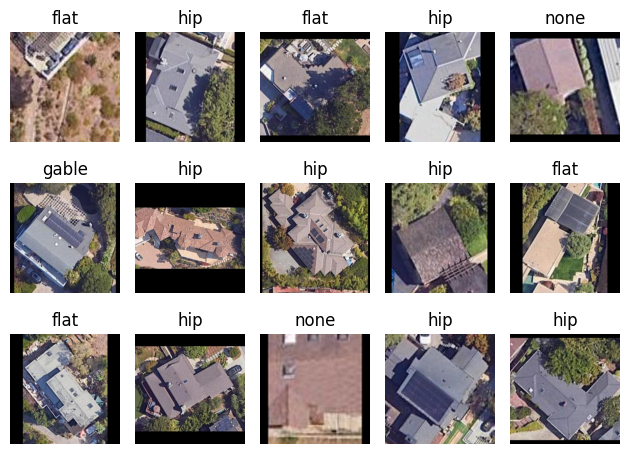

In [4]:
# RoofShape Classification
%matplotlib inline
plt.figure()
curr_dir = "tmp/satellite/"

for idx, (key, img) in enumerate(images_satellite.images.items()):
    filename = img.filename
    img_path = os.path.join(curr_dir, filename)
    img = mpimg.imread(img_path)    
    pred = predictions[key]
    plt.subplot(3, 5, idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred)
    plt.axis('off')
plt.tight_layout()
plt.margins(0,0)
plt.show()